## Step 1: Import libraries

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf

from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dense, \
    GlobalAveragePooling3D, BatchNormalization, Dropout, \
        UpSampling3D, concatenate, Flatten, ConvLSTM2D, Bidirectional, \
            Cropping3D, ZeroPadding3D, Activation, Input, UpSampling3D, \
                Conv3DTranspose
from tensorflow.keras.models import Sequential, save_model, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

%matplotlib inline

2023-03-13 20:38:45.532731: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Step 2: Set Constants

In [2]:
SEED = 137
# using the range from segmentation
# [40:195,35:225,26:137]
# constants to crop images

MIN_WIDTH = 29 # 40
MAX_WIDTH = 215 # 195

MIN_HEIGHT = 45 # 35
MAX_HEIGHT = 239 # 225

MIN_DEPTH = 15 # 26
MAX_DEPTH = 143 # 137

In [3]:
#channel 
channel = 'seg'

## Step 3: Load Data

In [7]:
# load data
df = pd.read_pickle(f"../raw_data/Grade_ID_nii.pkl")

# the target columns have to be updated, it's only the fremework
df['Grade'] = df['Grade'].apply(lambda x: 0 if x == 'HGG' else 1)

## Step 4: EDA

In [9]:
print(f"Number of samples: {df['nii'].shape[0]}")
print(f"Negative examples: {df[df['Grade'] == 0].shape}")
print(f"Positive examples: {df[df['Grade'] == 1].shape}")

print("")
print("Single example Shape:")
print(f"Height: {df['nii'][0].shape[0]}")
print(f"Width: {df['nii'][0].shape[1]}")
print(f"Depth: {df['nii'][0].shape[2]}")

Number of samples: 369
Negative examples: (293, 3)
Positive examples: (76, 3)

Single example Shape:
Height: 240
Width: 240
Depth: 155


## Step 5: Crop Images and run Augmentation

In [10]:
# crop images
df['nii'] = df['nii'].apply(lambda x: np.array(x[MIN_HEIGHT:MAX_HEIGHT,MIN_WIDTH:MAX_WIDTH,MIN_DEPTH:MAX_DEPTH]))
X = df['nii']
y = df['Grade']

In [11]:
# reshape input data
X = np.array([np.array(val) for val in X])


In [12]:
X = X.reshape(len(X), X[0].shape[0], X[0].shape[1], X[0].shape[2], 1)

In [13]:
def rotate_image(X, y, i):
    angles = [-30, -20, -15, -10, -5, 5, 10, 15, 20, 30] # set the list of angles to rotate image
    angle = random.choice(angles) # take the random angle from the list
    rotated_example = ndimage.rotate(X[i], angle, reshape=False) # run image rotation
    X = np.append(X, np.expand_dims(rotated_example, axis=0), axis=0) # append rotated image
    y = y.append(pd.Series([y[i]]), ignore_index=True) # append label
    
    return X, y

In [14]:
# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)
# reset the index of y, so that the indexes of X and y match
y_train = y_train.reset_index(drop=True)

y_test = y_test.reset_index(drop=True)

In [4]:
# conduct augmentation on X_train
if not os.path.isfile(f"{channel}-X_train.npy"):
    
    for i in range(len(X_train)):
        # we run augmentation only for positive examples, i.e. y[i] != 0
        if y_train[i] == 0:
            pass
        else:
            X_train,y_train = rotate_image(X_train, y_train, i)
            X_train,y_train = rotate_image(X_train, y_train, i)
    np.save(f"{channel}-X_train.npy", X_train) #save the channel-X so we don't need always augument the X
    np.save(f"{channel}-y_train.npy", y_train)
else:   #load the X direktly from npy file
    X_train = np.load(f"{channel}-X_train.npy",
                    mmap_mode='r')
    y_train = np.load(f"{channel}-y_train.npy",
                    mmap_mode='r')
    
    

In [5]:
# conduct augmentation on X_test
if not os.path.isfile(f"{channel}-X_test.npy"):
    
    for i in range(len(X_test)):
        # we run augmentation only for positive examples, i.e. y[i] != 0
        if y_test[i] == 0:
            pass
        else:
            X_test,y_test = rotate_image(X, y, i)
            X_test,y_test = rotate_image(X, y, i)
    np.save(f"{channel}-X_test.npy", X_test) #save the channel-X so we don't need always augument the X
    np.save(f"{channel}-y_test.npy", y_test)
else:   #load the X direkly from npy file
    X_test = np.load(f"{channel}-X_test.npy",
                    mmap_mode='r')
    y_test = np.load(f"{channel}-y_test.npy",
                    mmap_mode='r')

In [9]:
y_train.value_counts()

AttributeError: 'memmap' object has no attribute 'value_counts'

## Step 6: Define Model

In [6]:
in_layer = Input((194, 186, 128, 1))
bn = BatchNormalization()(in_layer)
cn1 = Conv3D(8, 
             kernel_size = (1, 5, 5), 
             padding = 'same',
             activation = 'relu')(bn)
cn2 = Conv3D(8, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(cn1)
bn2 = Activation('relu')(BatchNormalization()(cn2))

dn1 = MaxPooling3D((2, 2, 2))(bn2)
cn3 = Conv3D(16, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(dn1)
bn3 = Activation('relu')(BatchNormalization()(cn3))

dn2 = MaxPooling3D((1, 2, 2))(bn3)
cn4 = Conv3D(32, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(dn2)
bn4 = Activation('relu')(BatchNormalization()(cn4))

up1 = Conv3DTranspose(16, 
                      kernel_size = (3, 3, 3),
                      strides = (1, 2, 2),
                     padding = 'same')(bn4)

cat1 = concatenate([up1, bn3], axis=2)

up2 = Conv3DTranspose(8, 
                      kernel_size = (3, 3, 3),
                      strides = (2, 2, 2),
                     padding = 'same')(cat1)

pre_out = concatenate([up2, bn2], axis=2)

#pre_out
pre_out = Conv3D(1, 
             kernel_size = (1, 1, 1), 
             padding = 'same',
             activation = 'relu')(pre_out)

#pre_out = Cropping3D((1, 2, 2))(pre_out) # avoid skewing boundaries
#out = ZeroPadding3D((1, 2, 2))(pre_out)
#pre_out = Dense(512, activation = 'relu')(pre_out)    

pre_out = Flatten()(pre_out)

pre_out = Dense(16, activation = 'relu')(pre_out) 
out = Dense(1, activation='sigmoid')(pre_out)
sim_model = Model(inputs = [in_layer], outputs = [out])
sim_model.summary()


2023-03-13 20:36:32.671974: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-13 20:36:32.673382: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-13 20:36:32.826557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-13 20:36:32.829591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.62GiB deviceMemoryBandwidth: 298.08GiB/s
2023-03-13 20:36:32.829663: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-13 20:36:32.832392: I tensorflow/stream_executor/platform/default/dso_loade

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 194, 186, 12 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 194, 186, 128 4           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 194, 186, 128 208         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 194, 186, 128 1736        conv3d[0][0]                     
______________________________________________________________________________________________

In [6]:
##Sasha's but with sigmoid

in_layer = Input((194, 186, 128, 1))
bn = BatchNormalization()(in_layer)
cn1 = Conv3D(8, 
             kernel_size = (1, 5, 5), 
             padding = 'same',
             activation = 'relu')(bn)
bn2 = Activation('relu')(BatchNormalization()(cn1))

dn1 = MaxPooling3D((2, 2, 2))(bn2)
cn3 = Conv3D(16, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'relu')(dn1)
bn3 = Activation('relu')(BatchNormalization()(cn3))

dn2 = MaxPooling3D((1, 2, 2))(bn3)
cn4 = Conv3D(32, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'relu')(dn2)
bn4 = Activation('relu')(BatchNormalization()(cn4))

up1 = Conv3DTranspose(16, 
                      kernel_size = (3, 3, 3),
                      strides = (1, 2, 2),
                     padding = 'same')(bn4)

cat1 = concatenate([up1, bn3], axis=2)

up2 = Conv3DTranspose(8, 
                      kernel_size = (3, 3, 3),
                      strides = (2, 2, 2),
                     padding = 'same')(cat1)

pre_out = concatenate([up2, bn2], axis=2)

#pre_out
pre_out = Conv3D(1, 
             kernel_size = (1, 1, 1), 
             padding = 'same',
             activation = 'relu')(pre_out)

#pre_out = Cropping3D((1, 2, 2))(pre_out) # avoid skewing boundaries
#out = ZeroPadding3D((1, 2, 2))(pre_out)
#pre_out = Dense(512, activation = 'relu')(pre_out)    

pre_out = Flatten()(pre_out)

pre_out = Dense(32, activation = 'relu')(pre_out) 
out = Dense(1, activation='sigmoid')(pre_out)
sim_model = Model(inputs = [in_layer], outputs = [out])
sim_model.summary()


2023-03-13 20:39:11.254733: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-13 20:39:11.256007: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-13 20:39:11.409952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-13 20:39:11.412941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.62GiB deviceMemoryBandwidth: 298.08GiB/s
2023-03-13 20:39:11.413011: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-13 20:39:11.415626: I tensorflow/stream_executor/platform/default/dso_loade

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 194, 186, 12 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 194, 186, 128 4           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 194, 186, 128 208         batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 194, 186, 128 32          conv3d[0][0]                     
______________________________________________________________________________________________

In [7]:
optim=Adam(learning_rate= 0.001)
sim_model.compile(loss = 'binary_crossentropy',
                  optimizer = optim,
                  metrics = ['accuracy'])

In [14]:
print(f" Size of X_train: {(X_train.size * X_train.itemsize) / 1e9} Gb")

 Size of X_train: 7.704078336 Gb


## Step 7: Train Model

In [8]:
es = EarlyStopping(patience=5, restore_best_weights = True)
history = sim_model.fit(X_train, y_train,
                        epochs = 30,
                        batch_size = 2,
                        callbacks = [es],
                        validation_data=(X_test, y_test),
                        shuffle =True,
                        verbose = 1)
sim_model.save(f'model_glioma_{channel}_nii_UNET_baseline')

2023-03-13 20:39:20.848816: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-13 20:39:20.849359: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/30


2023-03-13 20:39:21.998405: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-13 20:39:22.342941: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-03-13 20:39:23.819921: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-03-13 20:39:23.905066: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


209/209 [==============================] - 188s 852ms/step - loss: 59.2205 - accuracy: 0.5343 - val_loss: 3.4206 - val_accuracy: 0.6432
Epoch 2/30
209/209 [==============================] - 170s 814ms/step - loss: 0.7130 - accuracy: 0.6594 - val_loss: 0.8025 - val_accuracy: 0.8243
Epoch 3/30
209/209 [==============================] - 171s 817ms/step - loss: 0.7675 - accuracy: 0.7138 - val_loss: 0.6336 - val_accuracy: 0.8216
Epoch 4/30
209/209 [==============================] - 171s 817ms/step - loss: 0.6145 - accuracy: 0.6699 - val_loss: 0.5912 - val_accuracy: 0.8405
Epoch 5/30
209/209 [==============================] - 171s 817ms/step - loss: 0.7668 - accuracy: 0.7240 - val_loss: 0.5800 - val_accuracy: 0.8649
Epoch 6/30
209/209 [==============================] - 170s 815ms/step - loss: 0.7398 - accuracy: 0.7369 - val_loss: 0.5561 - val_accuracy: 0.8730
Epoch 7/30
209/209 [==============================] - 170s 816ms/step - loss: 0.4790 - accuracy: 0.8064 - val_loss: 0.5728 - val_accur

2023-03-13 21:11:11.375980: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_glioma_seg_nii_UNET_baseline/assets


In [10]:
#save the history as pickle or smth else
results = {}
results['loss'] = history.history['loss']
results['accuracy'] = history.history['accuracy']
results['val_loss'] = history.history['val_loss']
results['val_accuracy'] = history.history['val_accuracy']

In [12]:
import json
with open(f'training_history_model_glioma_{channel}_nii_UNET_baseline.json', 'w') as f:
    json.dump(results, f)

In [18]:
results['loss']

[19.78541374206543,
 0.7758165597915649,
 0.8305395245552063,
 0.6044686436653137,
 0.6389635801315308,
 0.5917113423347473,
 0.4745553433895111,
 0.7840416431427002,
 0.49156251549720764,
 0.3990347981452942,
 0.40946444869041443]

In [14]:
#plot the learning curve
def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.2)
    ax1.grid(axis="y",linewidth=0.2)    
    
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.2)
    ax2.grid(axis="y",linewidth=0.2)    

    plt.show()    

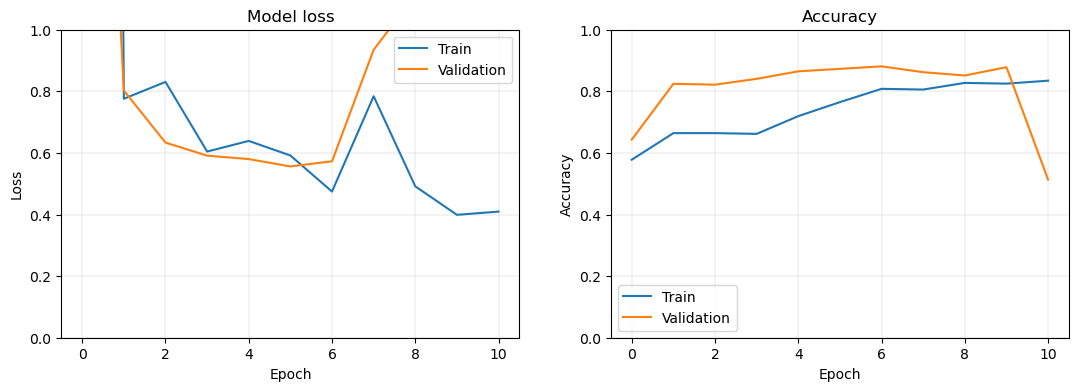

In [15]:
plot_loss(history)

In [ ]:
X_test = np.array([np.array(val) for val in X_test])
X_test = X_test.reshape(len(X_test), 194, 186, 128, 1)
X_test.shape

In [32]:
X_test_small = X_test[:7,:,:,:]
X_test_small.shape

(7, 194, 186, 128, 1)

In [66]:
X_test_large, X_test_small, y_test_large, y_test_small = train_test_split(X_test, y_test, test_size=0.1, stratify=y_test, random_state=SEED)

In [53]:
y_test_small

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
from sklearn.metrics import classification_report

In [68]:
X_test_small.shape[0]

37

In [ ]:
for i in range()

In [69]:
y_test_small

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0])

In [77]:
for i,_ in enumerate(range(0, X_test_small.shape[0], 5)):
    print(i)

0
1
2
3
4
5
6
7


In [102]:
len(predictions_list)

20

In [104]:
X_test_small_split

array([], shape=(0, 194, 186, 128, 1), dtype=int32)

In [103]:
sim_model.predict(X_test_small_split)

ValueError: Expect x to be a non-empty array or dataset.

In [106]:
split_end

55

In [115]:
split_start = 0
split_size = 5
split_end = split_start + split_size
predictions_raw = []
predictins_filtered = []

target_names = ['class 0', 'class 1']
PREDICTION_THRESHOLD = 0.5
for _ in range(0, X_test.shape[0], split_size):

    X_test_split = X_test[split_start:split_end,:,:,:]
    y_test_split = y_test[split_start:split_end]
    predictions_raw.extend(sim_model.predict(X_test_split).flatten().tolist())
    predictions = (sim_model.predict(X_test_split) > PREDICTION_THRESHOLD).astype("int32")
    predictins_filtered.extend(predictions.flatten().tolist())
    predictions = pd.DataFrame(predictions)
    
    split_start+=5
    split_end+=5
    
    try:
        print(classification_report(y_test_split, predictions, target_names=target_names))
    except:
        pass

/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       1.00      0.80      0.89         5
     class 1       0.00      0.00      0.00         0

    accuracy                           0.80         5
   macro avg       0.50      0.40      0.44         5
weighted avg       1.00      0.80      0.89         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       1.00      0.80      0.89         5
     class 1       0.00      0.00      0.00         0

    accuracy                           0.80         5
   macro avg       0.50      0.40      0.44         5
weighted avg       1.00      0.80      0.89         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       1.00      0.80      0.89         5
     class 1       0.00      0.00      0.00         0

    accuracy                           0.80         5
   macro avg       0.50      0.40      0.44         5
weighted avg       1.00      0.80      0.89         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       1.00      0.80      0.89         5
     class 1       0.00      0.00      0.00         0

    accuracy                           0.80         5
   macro avg       0.50      0.40      0.44         5
weighted avg       1.00      0.80      0.89         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       1.00      0.80      0.89         5
     class 1       0.00      0.00      0.00         0

    accuracy                           0.80         5
   macro avg       0.50      0.40      0.44         5
weighted avg       1.00      0.80      0.89         5

              precision    recall  f1-score   support

     class 0       0.75      0.75      0.75         4
     class 1       0.00      0.00      0.00         1

    accuracy                           0.60         5
   macro avg       0.38      0.38      0.38         5
weighted avg       0.60      0.60      0.60         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         0
     class 1       1.00      0.60      0.75         5

    accuracy                           0.60         5
   macro avg       0.50      0.30      0.37         5
weighted avg       1.00      0.60      0.75         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         0
     class 1       1.00      0.20      0.33         5

    accuracy                           0.20         5
   macro avg       0.50      0.10      0.17         5
weighted avg       1.00      0.20      0.33         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         0
     class 1       1.00      0.60      0.75         5

    accuracy                           0.60         5
   macro avg       0.50      0.30      0.37         5
weighted avg       1.00      0.60      0.75         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         0
     class 1       1.00      0.20      0.33         5

    accuracy                           0.20         5
   macro avg       0.50      0.10      0.17         5
weighted avg       1.00      0.20      0.33         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         0
     class 1       1.00      0.20      0.33         5

    accuracy                           0.20         5
   macro avg       0.50      0.10      0.17         5
weighted avg       1.00      0.20      0.33         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         0
     class 1       1.00      0.40      0.57         5

    accuracy                           0.40         5
   macro avg       0.50      0.20      0.29         5
weighted avg       1.00      0.40      0.57         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         0
     class 1       1.00      0.40      0.57         5

    accuracy                           0.40         5
   macro avg       0.50      0.20      0.29         5
weighted avg       1.00      0.40      0.57         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         0
     class 1       1.00      0.60      0.75         5

    accuracy                           0.60         5
   macro avg       0.50      0.30      0.37         5
weighted avg       1.00      0.60      0.75         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         0
     class 1       1.00      0.60      0.75         5

    accuracy                           0.60         5
   macro avg       0.50      0.30      0.37         5
weighted avg       1.00      0.60      0.75         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         0
     class 1       1.00      0.20      0.33         5

    accuracy                           0.20         5
   macro avg       0.50      0.10      0.17         5
weighted avg       1.00      0.20      0.33         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         0
     class 1       1.00      0.60      0.75         5

    accuracy                           0.60         5
   macro avg       0.50      0.30      0.37         5
weighted avg       1.00      0.60      0.75         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         0
     class 1       1.00      0.40      0.57         5

    accuracy                           0.40         5
   macro avg       0.50      0.20      0.29         5
weighted avg       1.00      0.40      0.57         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00       0.0
     class 1       0.00      0.00      0.00       5.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



In [118]:
results_pred = pd.DataFrame(
    {'predictions': predictins_filtered,
     'true_data': y_test.flatten().tolist()
    })

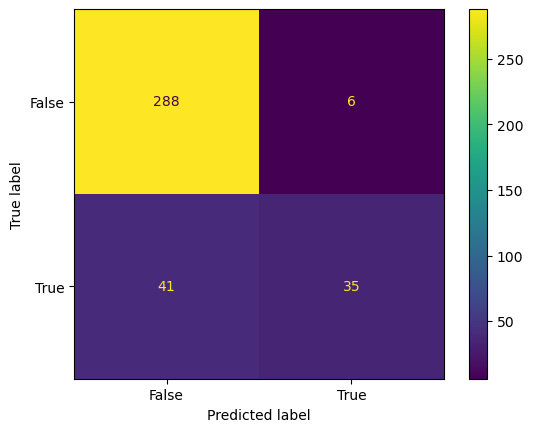

In [120]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(results_pred['true_data'], results_pred['predictions'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [54]:
X_test_small = X_test_small[:5,:,:,:]
X_test_small.shape

(5, 194, 186, 128, 1)

In [56]:
y_test_small = y_test_small[:5]
y_test_small

array([0, 0, 1, 0, 0])

In [57]:
y_pred_small = sim_model.predict(X_test_small)
y_pred_small.shape

(5, 1)

In [58]:
predictions = (sim_model.predict(X_test_small) > 0.5).astype("int32")
predictions.shape

(5, 1)

In [59]:
sim_model.evaluate(X_test_small, y_test_small)

1/1 [==============================] - 1s 578ms/step - loss: 0.6124 - accuracy: 0.8000


[0.6124274134635925, 0.800000011920929]

In [60]:
predictions

array([[0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [61]:
y_test_small

array([0, 0, 1, 0, 0])

In [ ]:
from sklearn.metrics import classification_report

In [62]:
predictions = (sim_model.predict(X_test_small) > 0.5).astype("int32")
predictions = pd.DataFrame(predictions)

from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test_small, predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.80      1.00      0.89         4
     class 1       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa